In [1]:
spark

In [2]:
# read file as a DataFrame
infile = '/home/cloudera/Desktop/KKBox_churn_predict/raw_data/members_v3.csv'
#infile = 'hdfs://master:8020/kkbox_churn/kkbox_data/raw_data/members_v3.csv'
df0 = spark.read.format('csv').option('header','true').option('sep',',').load(infile)

In [3]:
N = df0.count()
N

6769473

In [5]:
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- registration_init_time: string (nullable = true)



In [6]:
df0.show(5)

+--------------------+----+---+------+--------------+----------------------+
|                msno|city| bd|gender|registered_via|registration_init_time|
+--------------------+----+---+------+--------------+----------------------+
|Rb9UwLQTrxzBVwCB6...|   1|  0|  null|            11|              20110911|
|+tJonkh+O1CA796Fm...|   1|  0|  null|             7|              20110914|
|cV358ssn7a0f7jZOw...|   1|  0|  null|            11|              20110915|
|9bzDeJP6sQodK73K5...|   1|  0|  null|            11|              20110915|
|WFLY3s7z4EZsieHCt...|   6| 32|female|             9|              20110915|
+--------------------+----+---+------+--------------+----------------------+
only showing top 5 rows



## bd

In [21]:
# null value in column 'bd'?
from pyspark.sql.functions import isnull
df0.where(isnull('bd')).count()

0

In [23]:
# records with 'bd' = 0
from pyspark.sql.functions import col
df0.where(col('bd') == 0).count()

4540215

* ~2/3 of the members have 'bd' = 0

## gender 

In [20]:
from pyspark.sql.functions import isnull
df0.where(isnull('gender')).count()

4429505

* ~2/3 of the members do not have 'gender' data.

### bd and gender 

In [8]:
from pyspark.sql.functions import isnull
df0.where('bd == 0').where(isnull('gender')).count()

4388613

In [21]:
from pyspark.sql.functions import expr, isnull
df0.select(expr('bd == 0').alias('bd_is_0'), 
           expr('gender IS NULL').alias('gender_is_na')) \
   .groupBy('bd_is_0', 'gender_is_na').count().show()

+-------+------------+-------+
|bd_is_0|gender_is_na|  count|
+-------+------------+-------+
|   true|       false| 151602|
|   true|        true|4388613|
|  false|       false|2188366|
|  false|        true|  40892|
+-------+------------+-------+



* members with gender data mostly have 'bd' != 0
* members without gender data mostly have 'bd' = 0

* 65% of the members have gender = NA and 'bd' = 0
* 32% of the members have gender != NA and 'bd' != 0

### gender vs registration_init_time 

In [40]:
from pyspark.sql.functions import col, floor, isnull, count

#col1 = floor(col('registration_init_time').cast('int') / 200 - 0.5) * 2 + 1
col1 = floor(col('registration_init_time').cast('int') / 10000)
df_gender_na = df0.where(isnull('gender')) \
                  .select(col1.alias("year_na")) \
                  .groupBy("year_na").agg(count('year_na').alias('count_na'))
df_gender_nna = df0.where(~isnull('gender')) \
                  .select(col1.alias("year_nna")) \
                  .groupBy("year_nna").agg(count('year_nna').alias('count_nna'))

df = df_gender_na.join(df_gender_nna, df_gender_na.year_na == df_gender_nna.year_nna, 'outer')
df.show(50)

+-------+--------+--------+---------+
|year_na|count_na|year_nna|count_nna|
+-------+--------+--------+---------+
|   2007|      28|    2007|    89802|
|   2014|  549814|    2014|   425962|
|   2012|  103033|    2012|   180157|
|   2016| 1956253|    2016|   290508|
|   2009|    1215|    2009|    62418|
|   2010|   33396|    2010|    81679|
|   2006|      41|    2006|    53912|
|   2017|  400882|    2017|    80802|
|   2013|  324668|    2013|   200054|
|   null|    null|    2004|    26234|
|   2011|   60587|    2011|   118464|
|   2005|      71|    2005|    41278|
|   2008|      28|    2008|    67662|
|   2015|  999489|    2015|   621036|
+-------+--------+--------+---------+



In [45]:
df_1 = df.selectExpr('year_nna as year', 'count_na as', 'count_nna').sort('year')
df_1.show(20)

+----+--------+---------+
|year|count_na|count_nna|
+----+--------+---------+
|2004|    null|    26234|
|2005|      71|    41278|
|2006|      41|    53912|
|2007|      28|    89802|
|2008|      28|    67662|
|2009|    1215|    62418|
|2010|   33396|    81679|
|2011|   60587|   118464|
|2012|  103033|   180157|
|2013|  324668|   200054|
|2014|  549814|   425962|
|2015|  999489|   621036|
|2016| 1956253|   290508|
|2017|  400882|    80802|
+----+--------+---------+



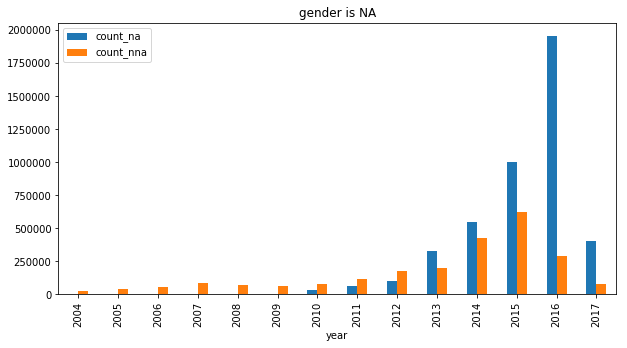

In [51]:
import matplotlib.pyplot as plt
df_1.toPandas().set_index('year').plot(kind='bar', figsize=(10,5), title='gender is NA')
plt.show()

# count_na: count of members no gender data
# count_nna: count of members with gender data

## city 

In [49]:
from pyspark.sql.functions import col
df0.groupBy('city').count().sort(col('city').cast('int')).show(40)

+----+-------+
|city|  count|
+----+-------+
|   1|4804326|
|   3|  27282|
|   4| 246848|
|   5| 385069|
|   6| 135200|
|   7|  11610|
|   8|  45975|
|   9|  47639|
|  10|  32482|
|  11|  47489|
|  12|  66843|
|  13| 320978|
|  14|  89940|
|  15| 190213|
|  16|   5092|
|  17|  27772|
|  18|  38039|
|  19|   1199|
|  20|   4233|
|  21|  30837|
|  22| 210407|
+----+-------+



## registered_via

In [27]:
df0.groupBy('registered_via').count() \
   .sort(col('registered_via').cast('int')).show()

+--------------+-------+
|registered_via|  count|
+--------------+-------+
|            -1|      1|
|             1|     43|
|             2|   1452|
|             3|1643208|
|             4|2793213|
|             5|   3115|
|             6|   1213|
|             7| 805895|
|             8|   3982|
|             9|1482863|
|            10|     10|
|            11|  25047|
|            13|   5455|
|            14|    615|
|            16|    888|
|            17|   1494|
|            18|      5|
|            19|    974|
+--------------+-------+



### registered_via and gender 

In [80]:
df = df0.selectExpr('registered_via as reg_via', 'gender IS NULL AS gender_na') \
        .stat.crosstab('reg_via', 'gender_na').sort(col('reg_via_gender_na').cast('int'))
df.printSchema()
df.show(20)

root
 |-- reg_via_gender_na: string (nullable = true)
 |-- false: long (nullable = true)
 |-- true: long (nullable = true)

+-----------------+-------+-------+
|reg_via_gender_na|  false|   true|
+-----------------+-------+-------+
|               -1|      0|      1|
|                1|      4|     39|
|                2|    171|   1281|
|                3|1211468| 431740|
|                4| 256291|2536922|
|                5|    137|   2978|
|                6|     58|   1155|
|                7| 114854| 691041|
|                8|    384|   3598|
|                9| 750713| 732150|
|               10|      0|     10|
|               11|   5210|  19837|
|               13|    414|   5041|
|               14|    176|    439|
|               16|      0|    888|
|               17|     17|   1477|
|               18|      0|      5|
|               19|     71|    903|
+-----------------+-------+-------+



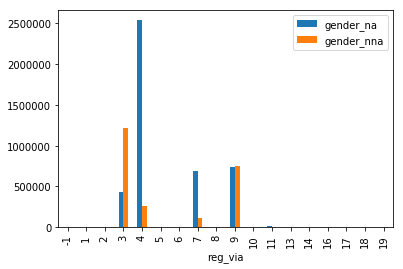

In [81]:
import matplotlib.pyplot as plt
df.selectExpr('reg_via_gender_na as reg_via', '`true` as gender_na', '`false` as gender_nna') \
  .toPandas().set_index('reg_via').plot(kind='bar')

plt.show()

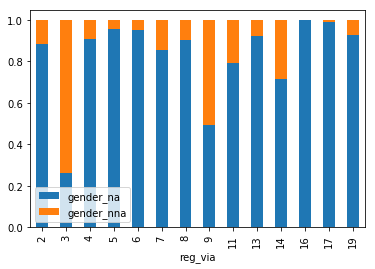

In [85]:
import matplotlib.pyplot as plt
df.where(col('true') + col('false') > 100) \
  .selectExpr('reg_via_gender_na as reg_via',
              '`true`/(`true`+`false`) as gender_na',
              '`false`/(`true`+`false`) as gender_nna') \
  .toPandas().set_index('reg_via').plot(kind='bar', stacked=True)

plt.show()

# gender_na: percentage of members without gender data
# gender_nna: percentage of members with gender data

* register method 3 and 9 have relatively high ratio of members with gender data